In [162]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import math
import random
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
os.chdir('/mnt/BioAdHoc/Groups/vd-ay/kfetter/hichip-db-loop-calling')

#### Input Parameters

In [163]:
sample = "CD34+-Cord-Blood.GSE165207.Homo_Sapiens.H3K27ac.b1"

In [164]:
hicpro = "results/revisions/alignment_comparison/loops/{s}/S5_hicpro/FitHiChIP_Peak2ALL_b5000_L20000_U2000000/P2PBckgr_1/Coverage_Bias/FitHiC_BiasCorr/FitHiChIP-S5.interactions_FitHiC_Q0.01.bed".format(s = sample)
juicer = "results/revisions/alignment_comparison/loops/{s}/S5_juicer/FitHiChIP_Peak2ALL_b5000_L20000_U2000000/P2PBckgr_1/Coverage_Bias/FitHiC_BiasCorr/FitHiChIP-S5.interactions_FitHiC_Q0.01.bed".format(s = sample)
distiller = "results/revisions/alignment_comparison/loops/{s}/S5_distiller/FitHiChIP_Peak2ALL_b5000_L20000_U2000000/P2PBckgr_1/Coverage_Bias/FitHiC_BiasCorr/FitHiChIP-S5.interactions_FitHiC_Q0.01.bed".format(s = sample)
chrom_sizes = "/mnt/BioAdHoc/Groups/vd-ay/Database_HiChIP_eQTL_GWAS/Data/RefGenome/chrsize/hg38.chrom.sizes"

#### Load Sequences

In [165]:
def get_vecs_contacts(file, chrom):
    anchors = [] # represented by start coordinate of anchor
    contact_counts = []
    with open(file) as f:
        first_line = True
        for line in f:
            if not first_line:
                info = line.strip().split("\t")
                if info[0] == chrom:
                    anchors.append(int(info[1]))
                    anchors.append(int(info[4]))
                    contact_counts.append(int(info[6]))
                    contact_counts.append(int(info[6]))
            first_line = False
    return anchors, contact_counts

In [166]:
def get_vecs_loops(file, chrom):
    anchors = [] # represented by start coordinate of anchor
    loop_counts = []
    with open(file) as f:
        first_line = True
        for line in f:
            if not first_line:
                info = line.strip().split("\t")
                if info[0] == chrom:
                    anchors.append(int(info[1]))
                    anchors.append(int(info[4]))
                    loop_counts.append(1)
                    loop_counts.append(1)
            first_line = False
    return anchors, loop_counts

In [246]:
def get_coverage(chrom, analysis):
    window_sizes = {"contacts" : 1000000, "loops" : 10000}
    bin_sizes_label = {"contacts" : "1mb", "loops" : "10kb"}
    window = window_sizes[analysis]
    
    # load chrom sizes
    sizes = {}
    with open(chrom_sizes) as c:
        for line in c:
            info = line.strip().split("\t")
            sizes[info[0]] = int(info[1])
    
    # get anchors and counts lists
    if analysis == "contacts":
        anchors_hicpro, counts_hicpro = get_vecs_contacts(hicpro, chrom)
        anchors_distiller, counts_distiller = get_vecs_contacts(distiller, chrom)
        anchors_juicer, counts_juicer = get_vecs_contacts(juicer, chrom)
    elif analysis == "loops":
        anchors_hicpro, counts_hicpro = get_vecs_loops(hicpro, chrom)
        anchors_distiller, counts_distiller = get_vecs_loops(distiller, chrom)
        anchors_juicer, counts_juicer = get_vecs_loops(juicer, chrom)
    
    # define the number of bins
    num_bins = -(sizes[chrom] // -window) # ceiling division

    # create bins
    bins = np.linspace(0, sizes[chrom], num_bins + 1)

    # Assign values to bins
    bin_indices_hicpro = np.digitize(anchors_hicpro, bins)
    bin_indices_distiller = np.digitize(anchors_distiller, bins)
    bin_indices_juicer = np.digitize(anchors_juicer, bins)
    
    # ensure that the bin_sums have the same length by artifically placing the max bin index into bin_indices with count 0
    max_index = max(max(bin_indices_hicpro), max(bin_indices_distiller), max(bin_indices_juicer)) 
    if max(bin_indices_hicpro) != max_index:
        bin_indices_hicpro = np.append(bin_indices_hicpro, max_index)
        counts_hicpro = np.append(counts_hicpro, 0)
    if max(bin_indices_distiller) != max_index:
        bin_indices_distiller = np.append(bin_indices_distiller, max_index)
        counts_distiller = np.append(counts_distiller, 0)
    if max(bin_indices_juicer) != max_index:
        bin_indices_juicer = np.append(bin_indices_juicer, max_index)
        counts_juicer = np.append(counts_juicer, 0)

    # Calculate the sum of values in each bin
    bin_sums_hicpro = np.bincount(bin_indices_hicpro, weights=counts_hicpro)
    bin_sums_distiller = np.bincount(bin_indices_distiller, weights=counts_distiller)
    bin_sums_juicer = np.bincount(bin_indices_juicer, weights=counts_juicer)
    
    # upper bins may not be used at higher resolution, so remove these bins
    if len(bins) != len(bin_sums_hicpro):
        bins = bins[:len(bin_sums_hicpro)]
    
    # plot figure 
    sns.set_style("white")
    fig, ax = plt.subplots(1, 4, figsize=(30, 4), gridspec_kw={'width_ratios': [2.5, 1, 1, 1]})
    
    ax[0].stairs(bin_sums_distiller[1:], bins, color="red", label="distiller-nf")
    ax[0].stairs(bin_sums_juicer[1:], bins, color="green", label="Juicer")
    ax[0].stairs(bin_sums_hicpro[1:], bins, color="blue", label="HiC-Pro")
    ax[0].set_xlabel(bin_sizes_label[analysis] + " Genomic Bins")
    if analysis == "contacts":
        ax[0].set_ylabel("Contact Count")
    elif analysis == "loops":
        ax[0].set_ylabel("Number of Loops")
    ax[0].legend()
    
    data = [sum(counts_hicpro) / 2, sum(counts_distiller) / 2, sum(counts_juicer) / 2]
    x_labels = ["HiC-Pro", "Juicer", "distiller-nf"]
    ax[1].bar(x_labels, data, color=["blue", "green", "red"], edgecolor='black')
    if analysis == "contacts":
        ax[1].set_ylabel("Contact Count")
    elif analysis == "loops":
        ax[1].set_ylabel("Number of Loops")
    
    data = [len(set(bin_indices_hicpro)), len(set(bin_indices_distiller)), len(set(bin_indices_juicer))]
    x_labels = ["HiC-Pro", "Juicer", "distiller-nf"]
    ax[2].bar(x_labels, data, color=["blue", "green", "red"], edgecolor='black')
    ax[2].set_ylabel("Number of " + bin_sizes_label[analysis] + " Genomic Bins Covered")

    data = np.array([bin_sums_hicpro, bin_sums_juicer, bin_sums_distiller])
    corr_matrix = np.corrcoef(data)

    sns.heatmap(corr_matrix, annot=True, fmt=".4f", cmap='coolwarm', yticklabels=["HiC-Pro", "Juicer", "distiller-nf"], xticklabels=["HiC-Pro", "Juicer", "distiller-nf"])
    fig.suptitle(chrom, fontsize=14)
    fig.savefig("results/revisions/alignment_comparison/loops/CD34+-Cord-Blood.GSE165207.Homo_Sapiens.H3K27ac.b1/figures/{a}_{c}.png".format(a = analysis, c = chrom), dpi = 1000, bbox_inches="tight")
    plt.show

#### Contacts Plots

/mnt/hpcscratch/nodescratch/login02/ipykernel_849452/2002618702.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 4, figsize=(30, 4), gridspec_kw={'width_ratios': [2.5, 1, 1, 1]})


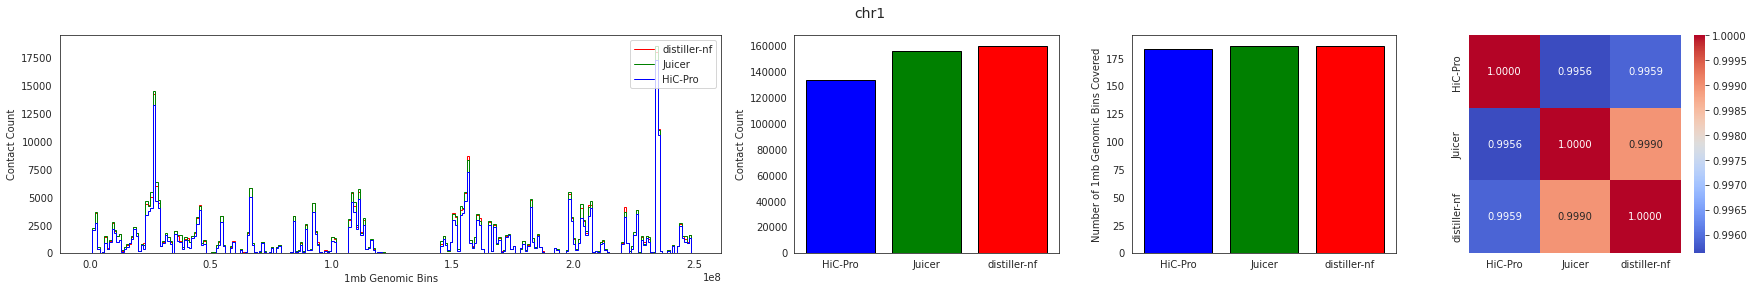

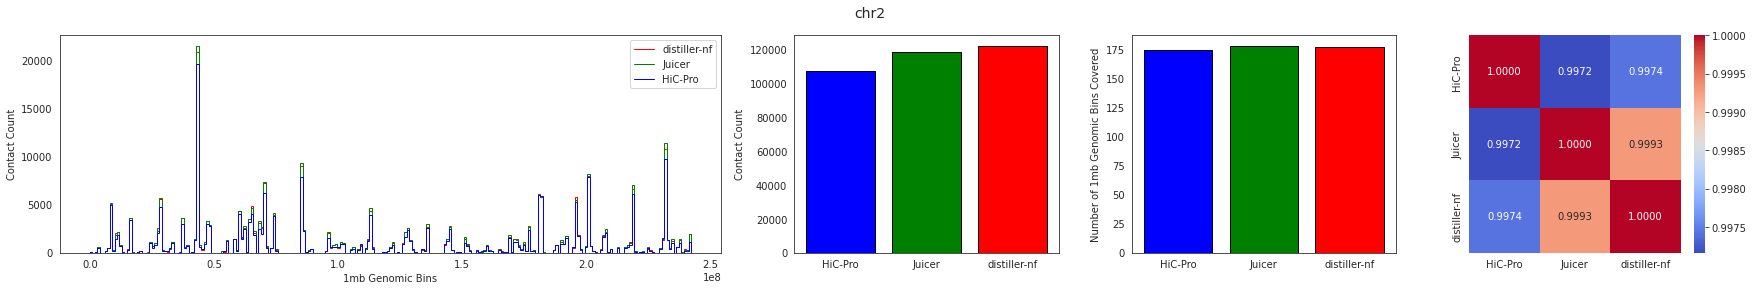

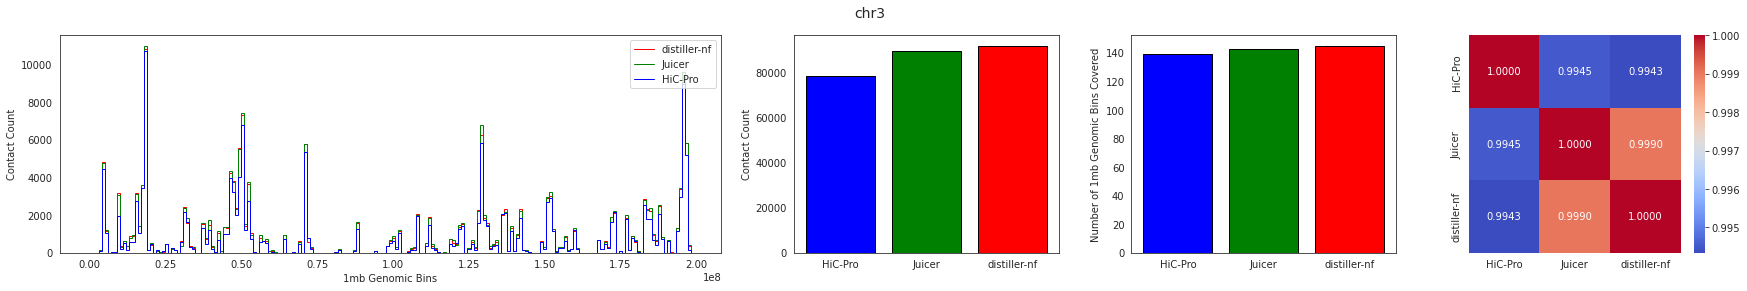

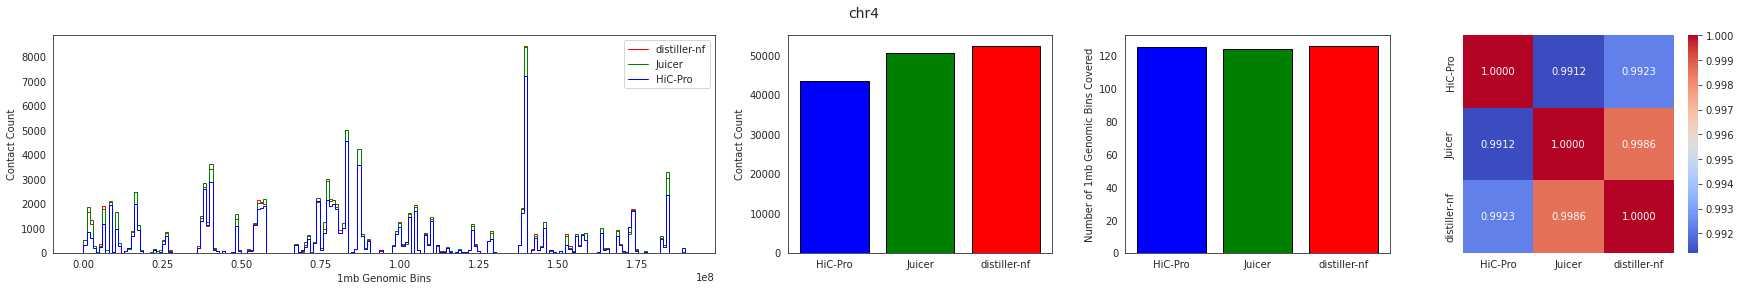

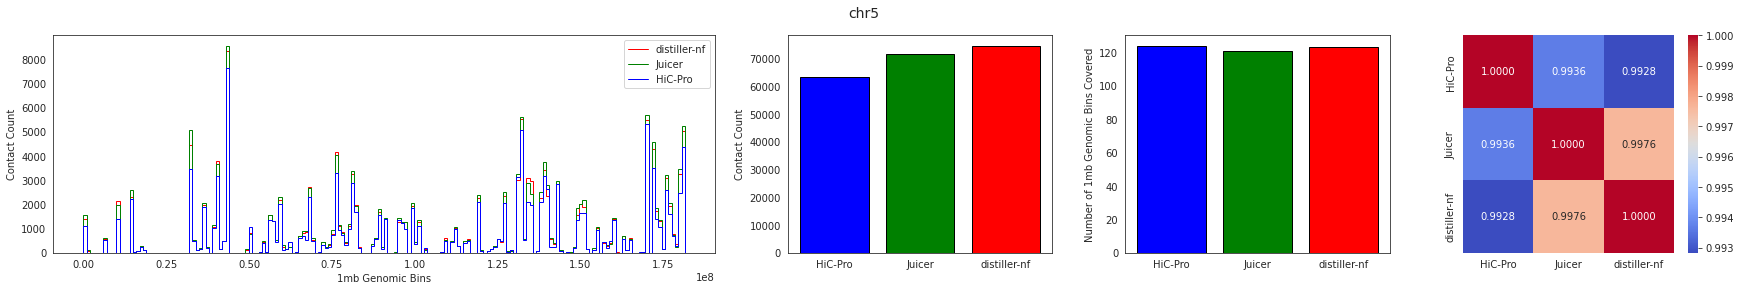

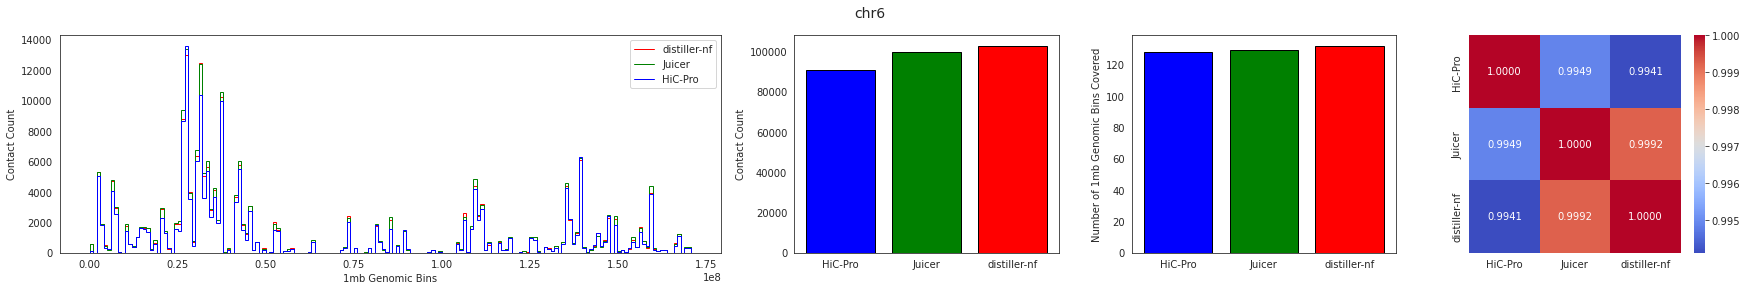

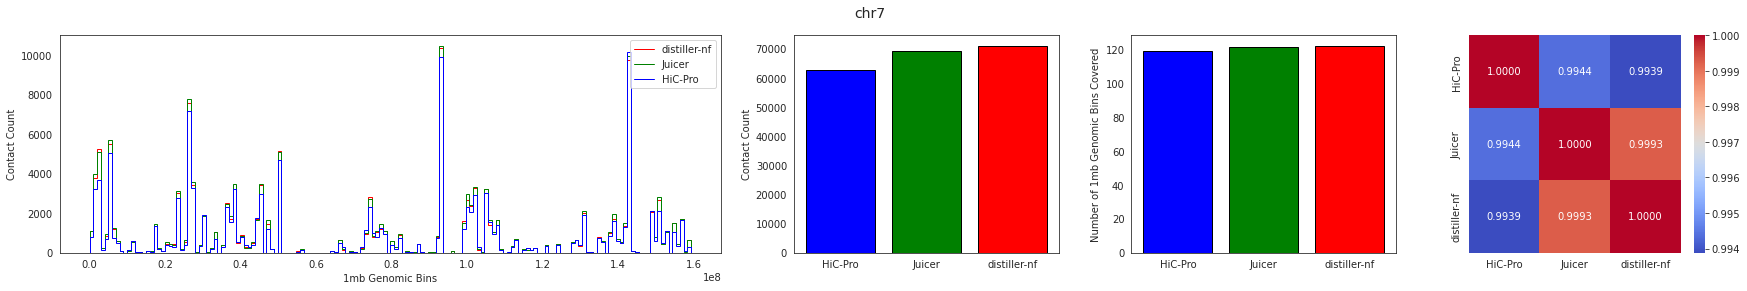

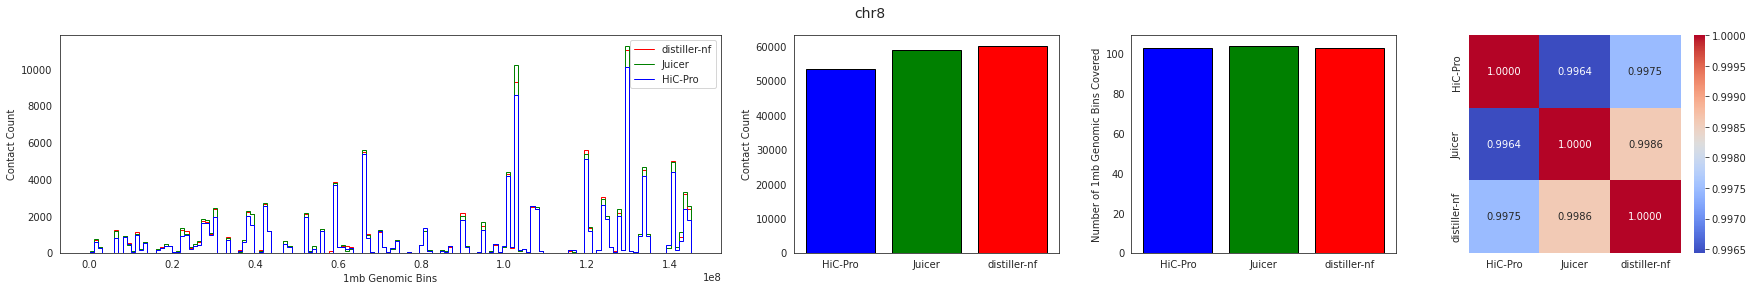

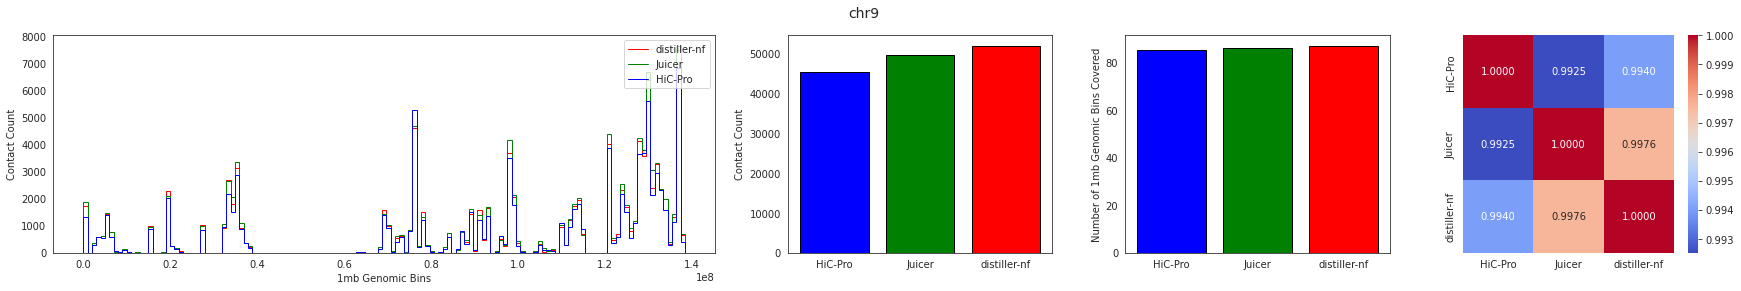

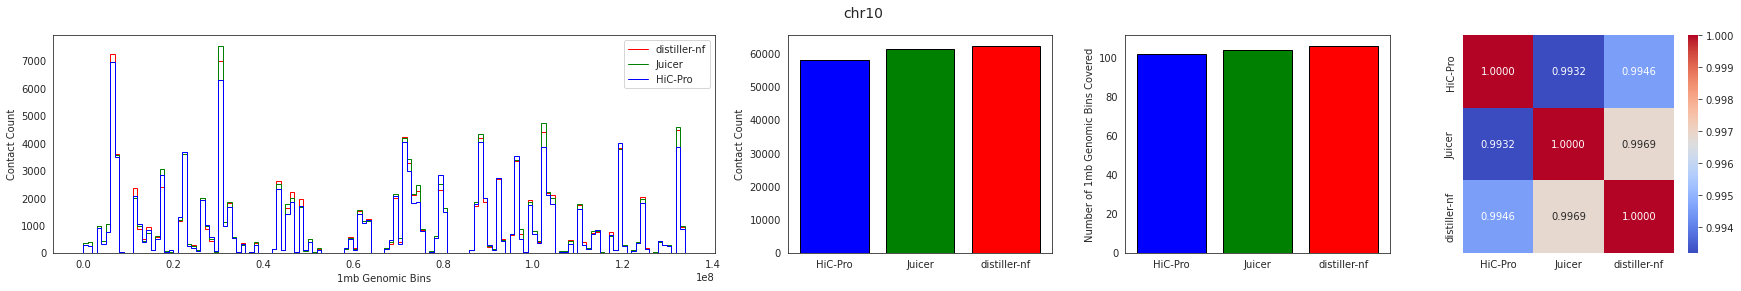

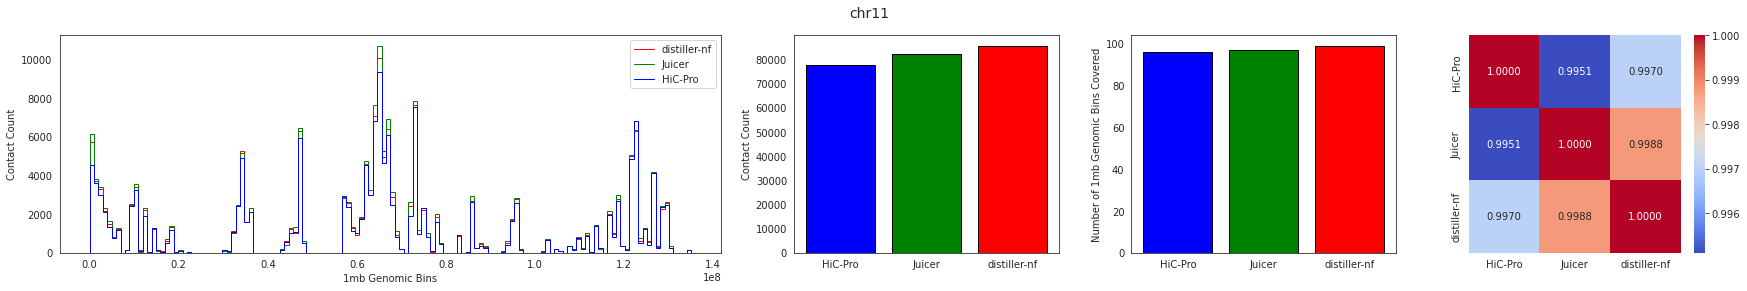

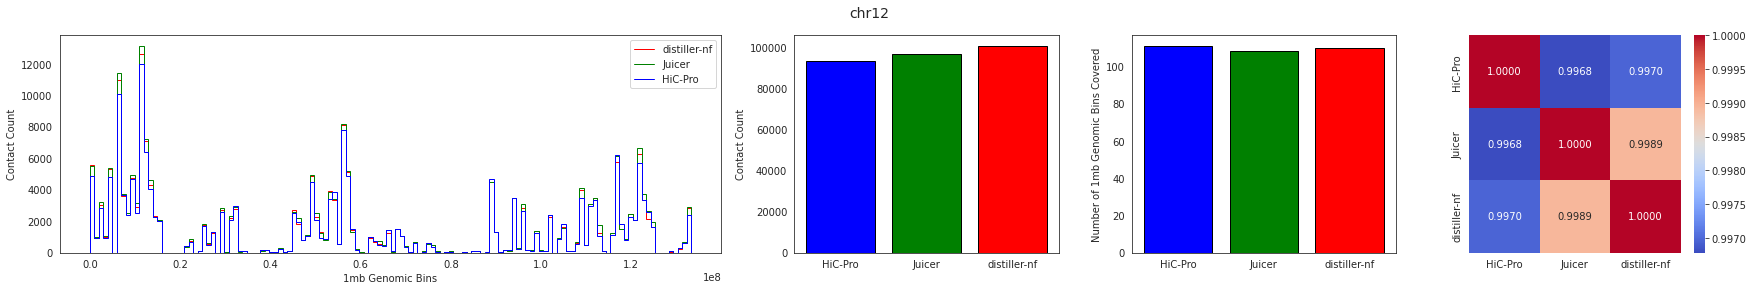

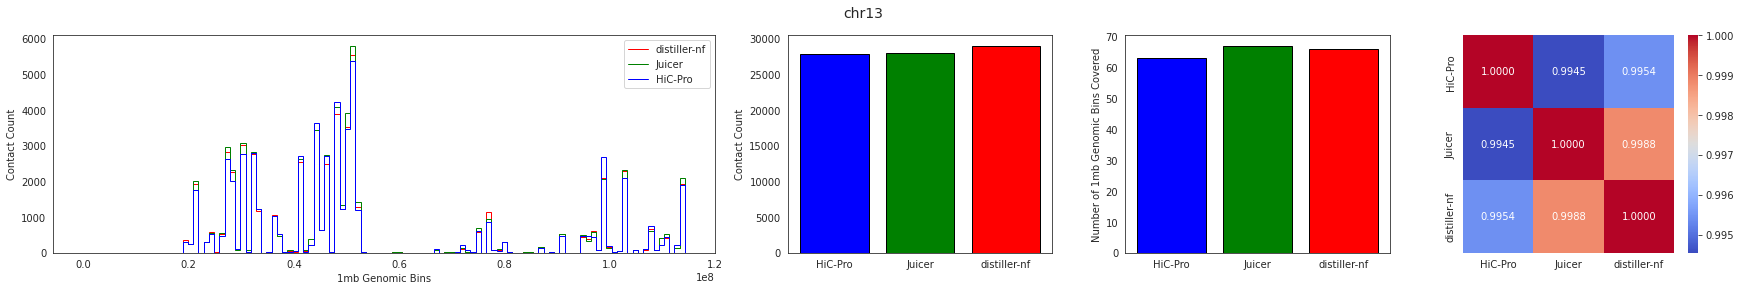

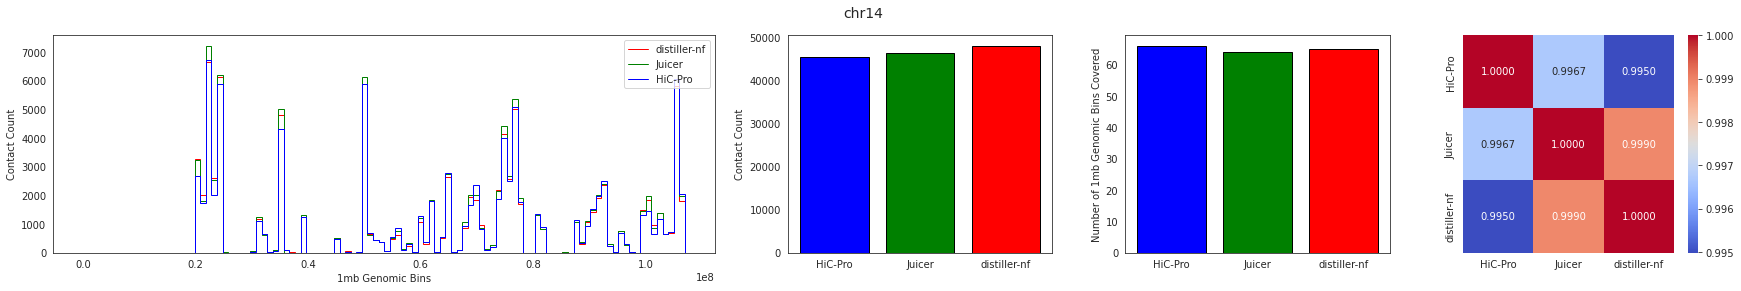

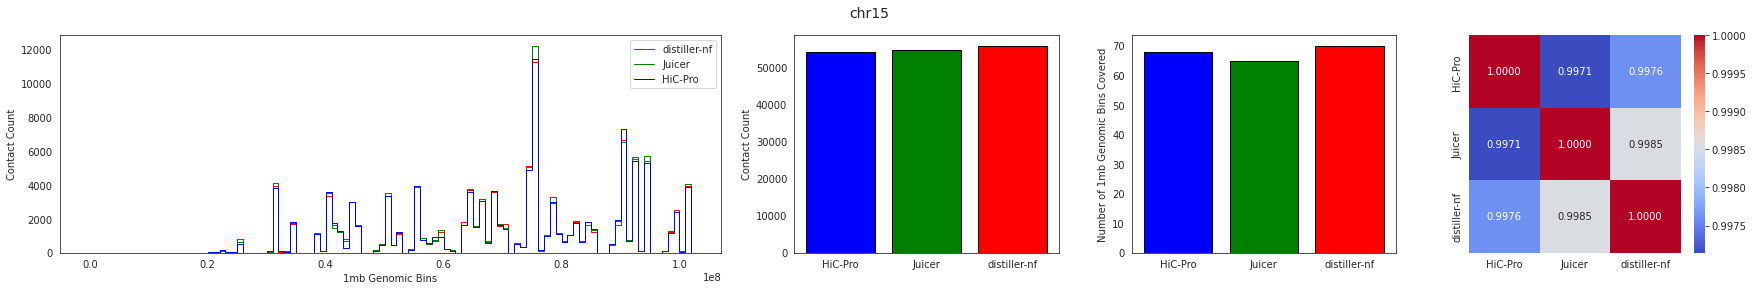

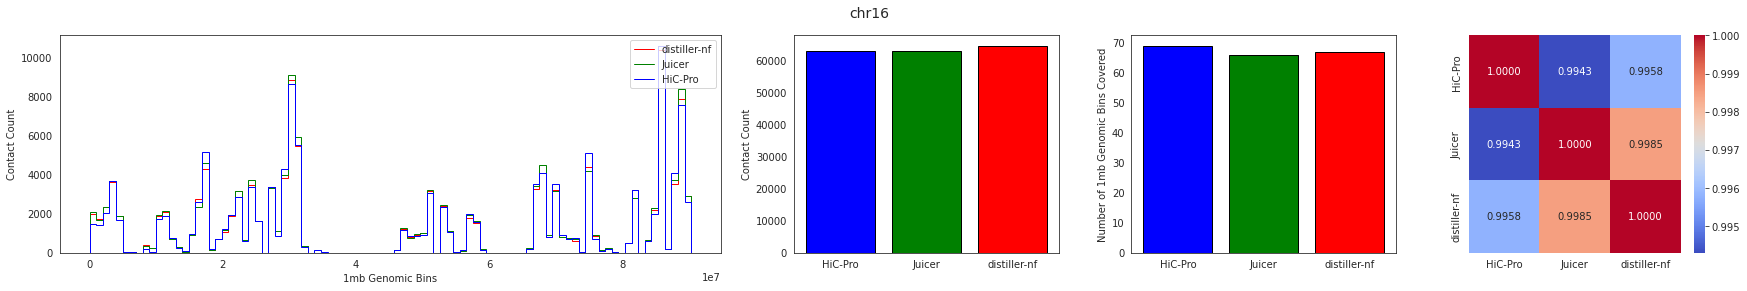

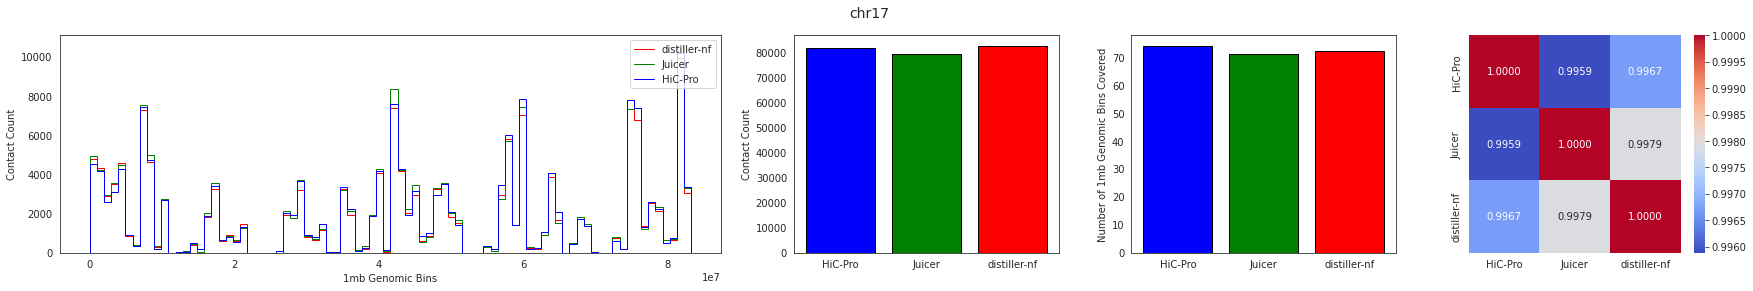

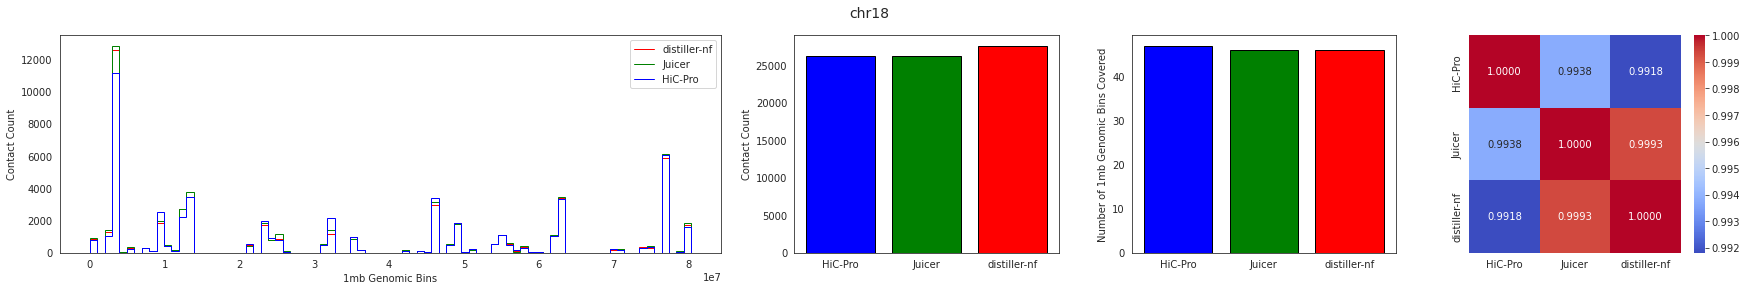

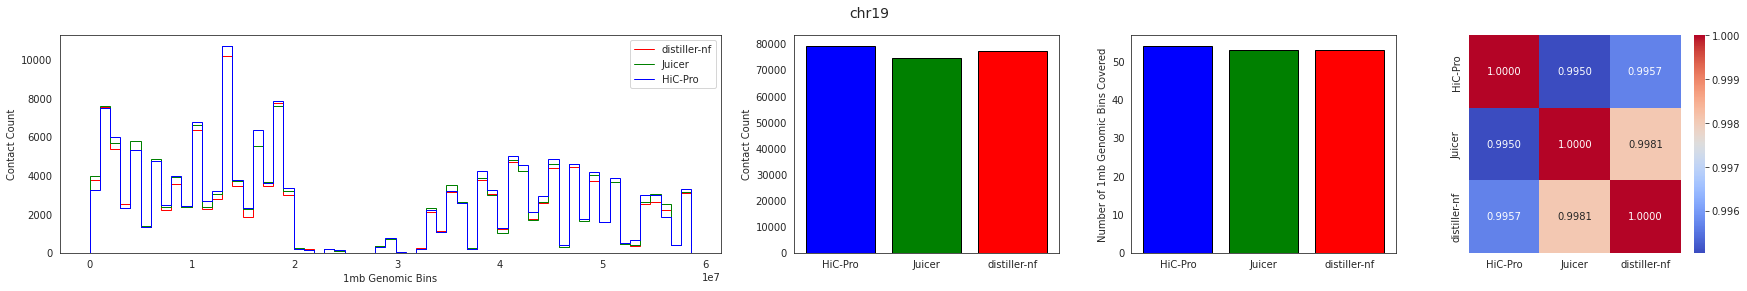

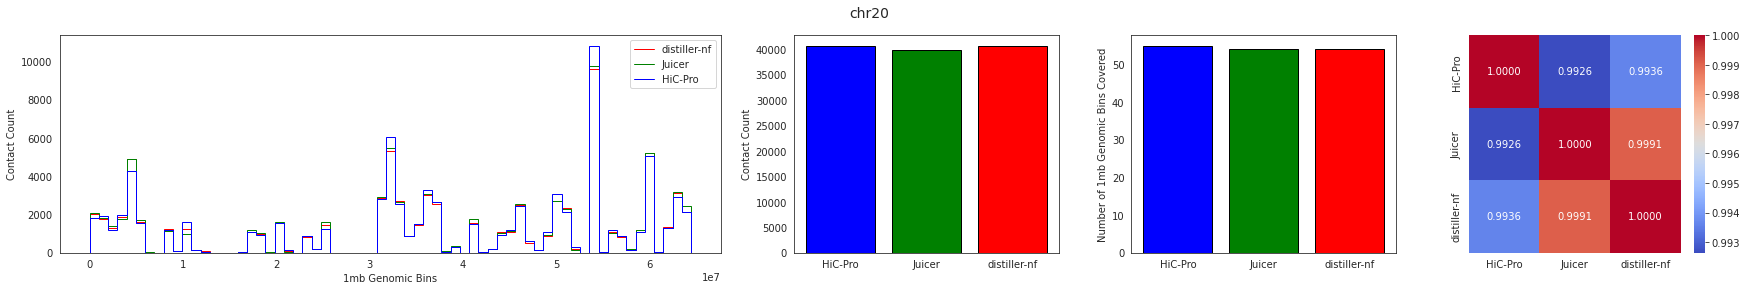

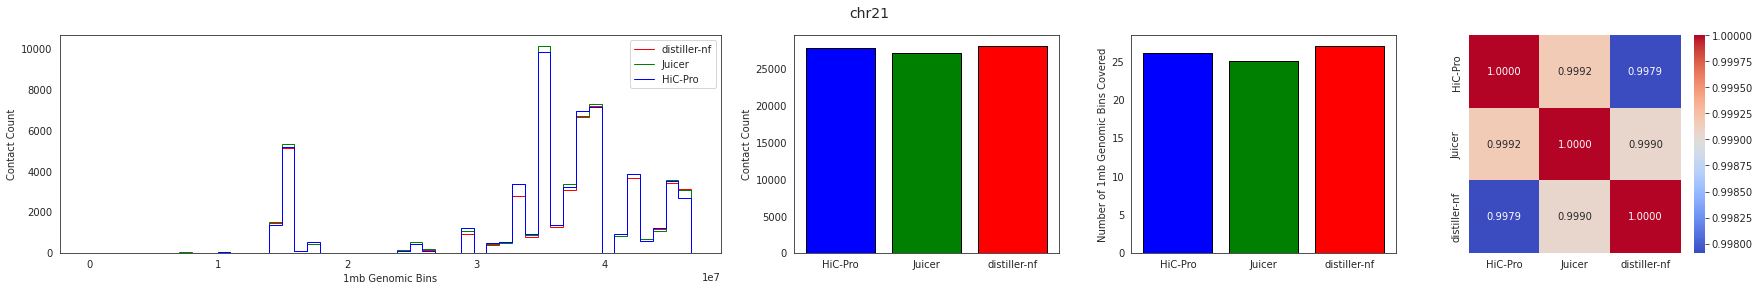

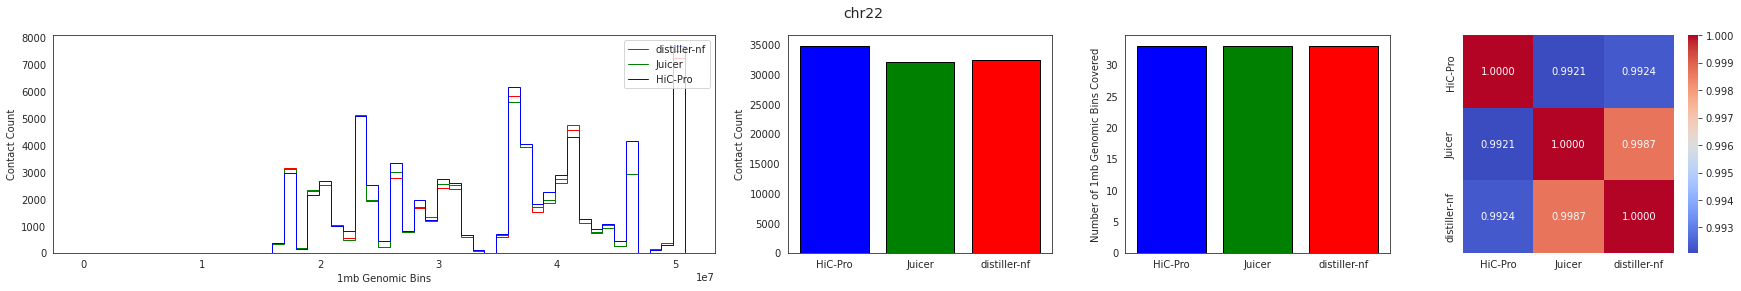

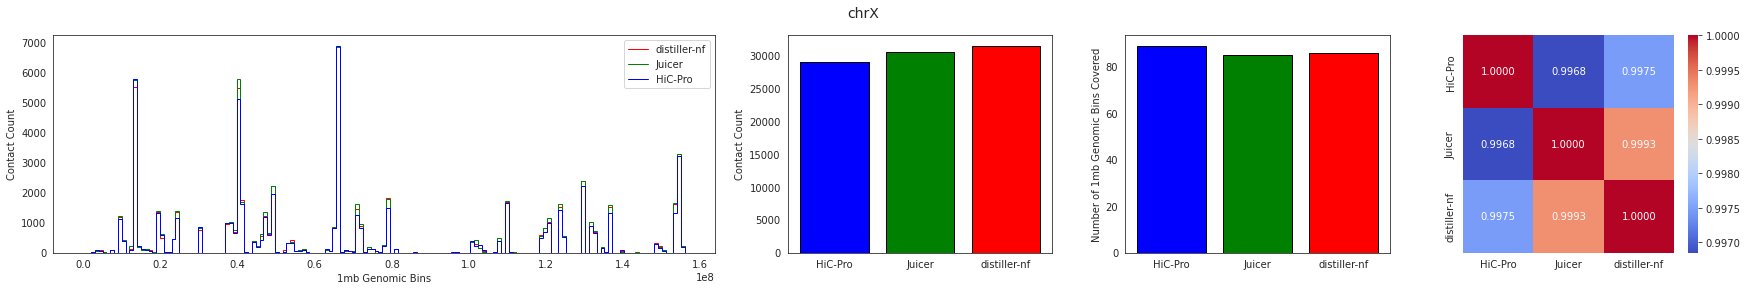

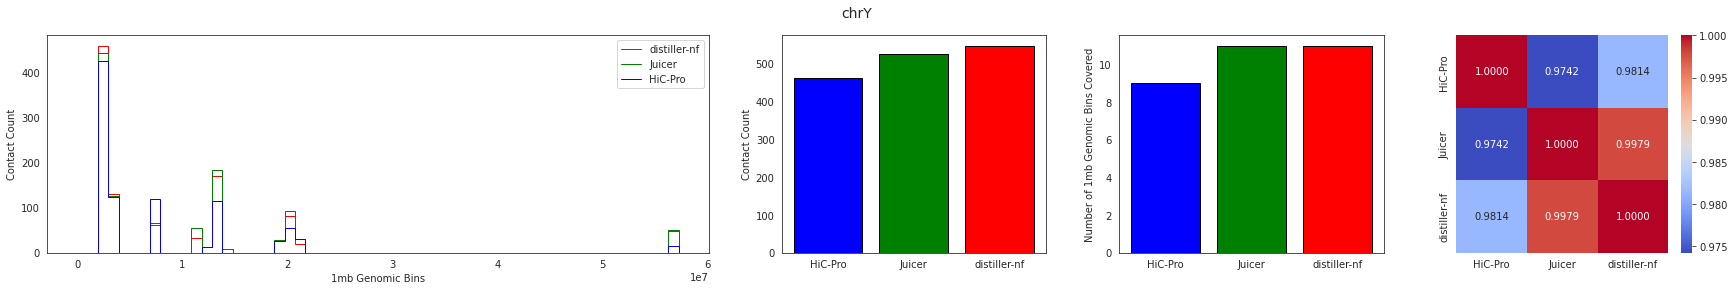

In [247]:
chroms = ["chr" + str(n) for n in range(1, 23)]
chroms.append("chrX")
chroms.append("chrY")
for chrom in chroms:
    get_coverage(chrom, "contacts")

#### Loops Plots

/mnt/hpcscratch/nodescratch/login02/ipykernel_849452/2002618702.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 4, figsize=(30, 4), gridspec_kw={'width_ratios': [2.5, 1, 1, 1]})


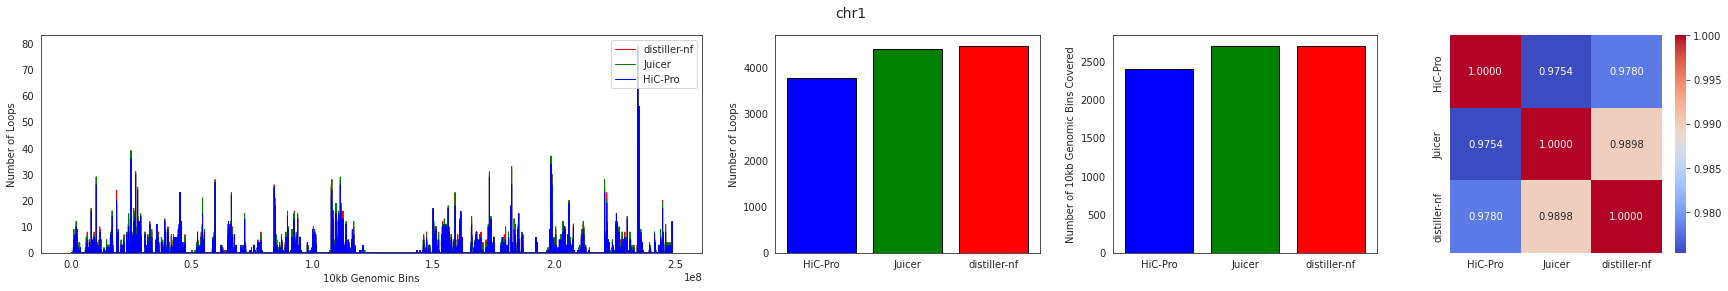

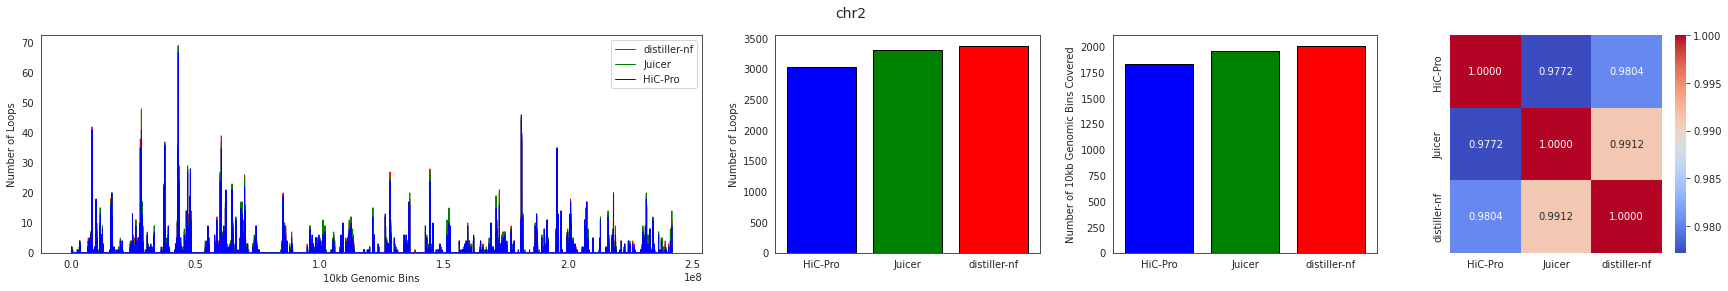

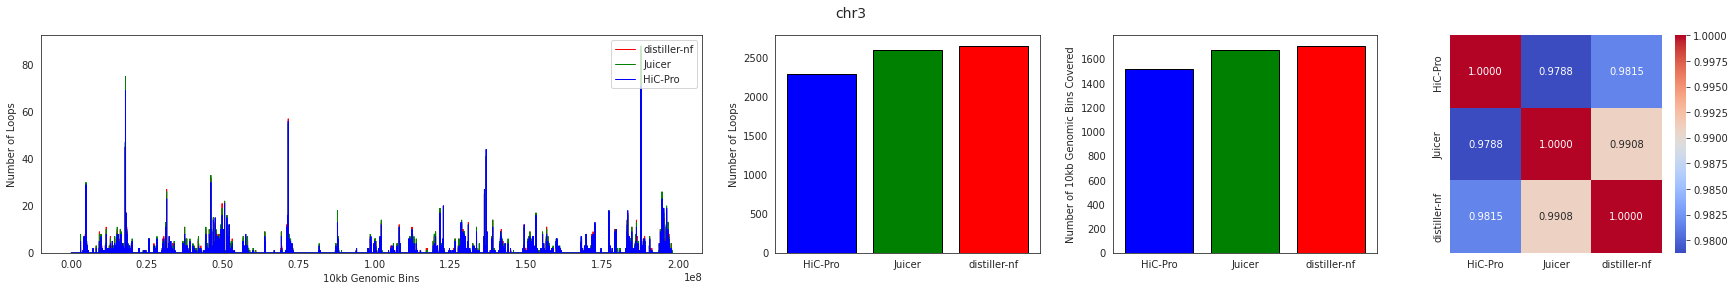

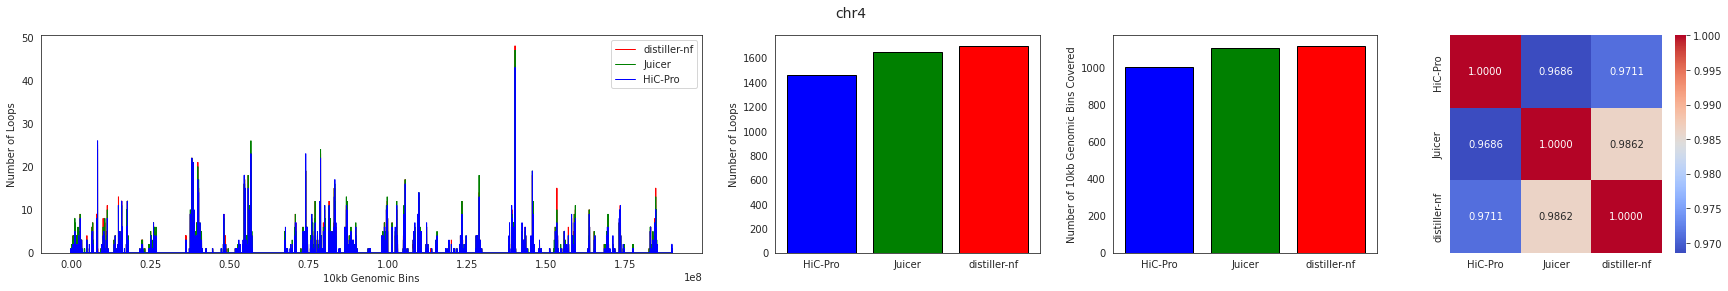

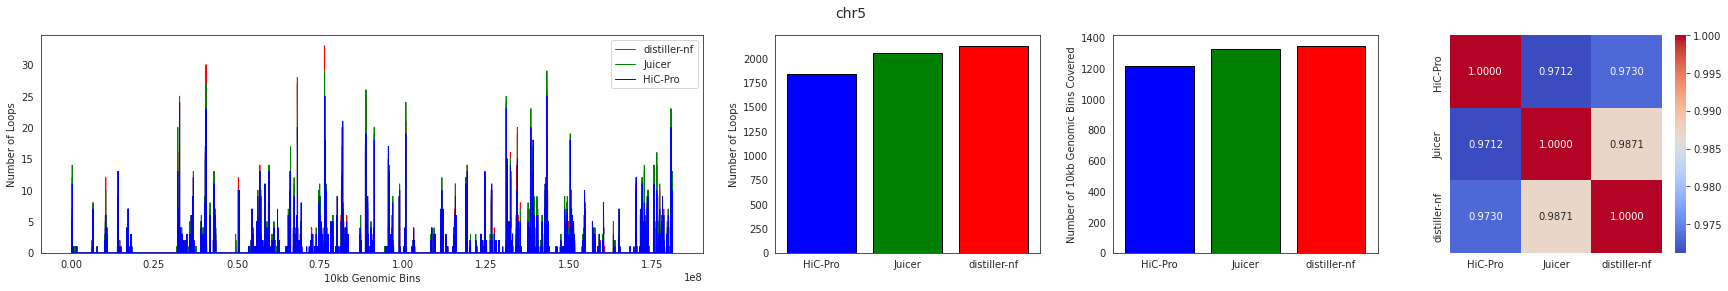

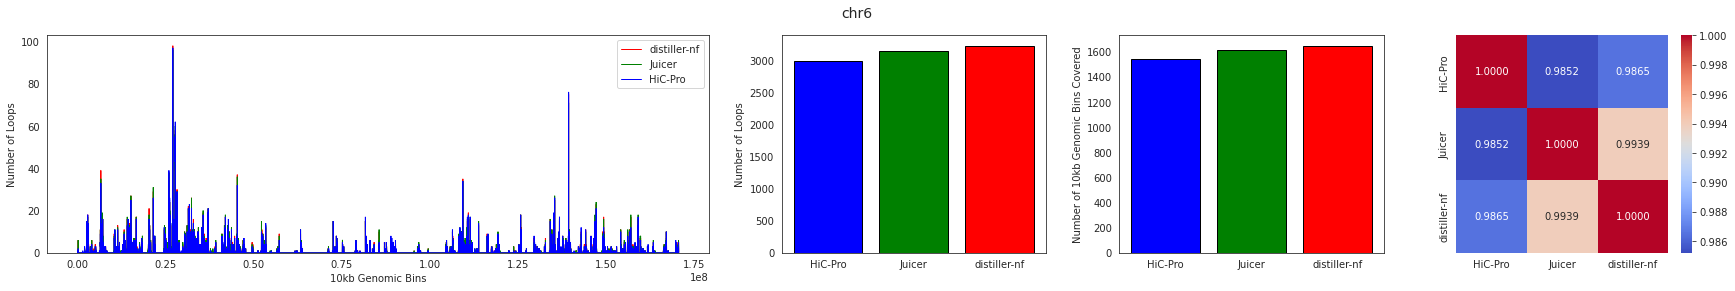

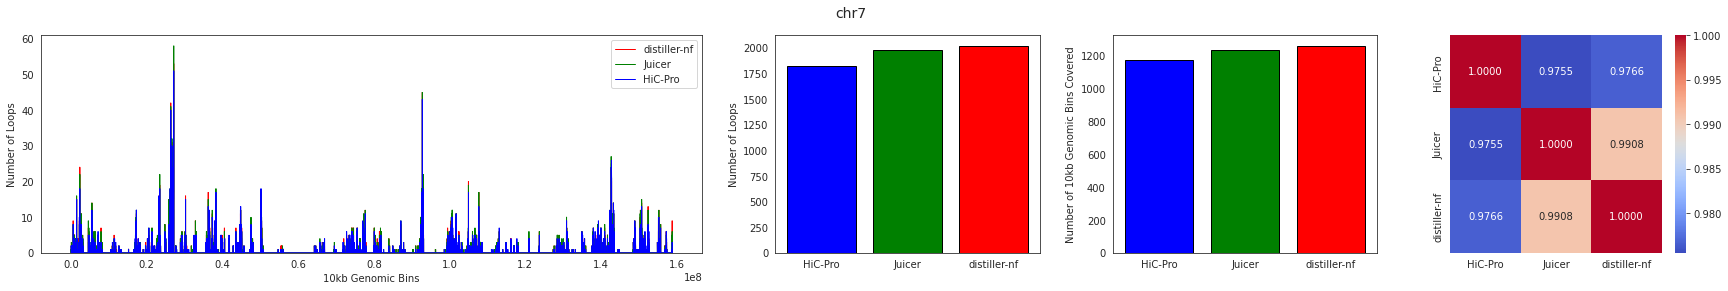

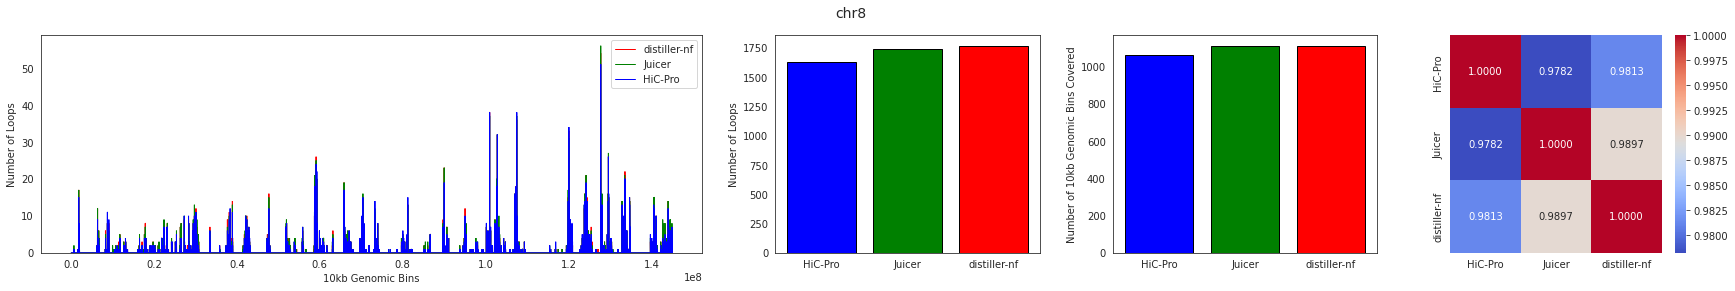

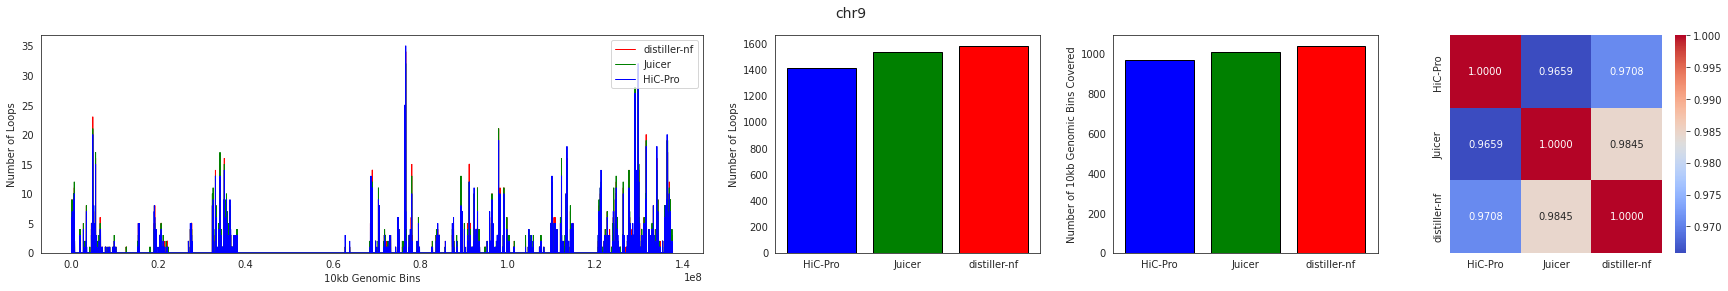

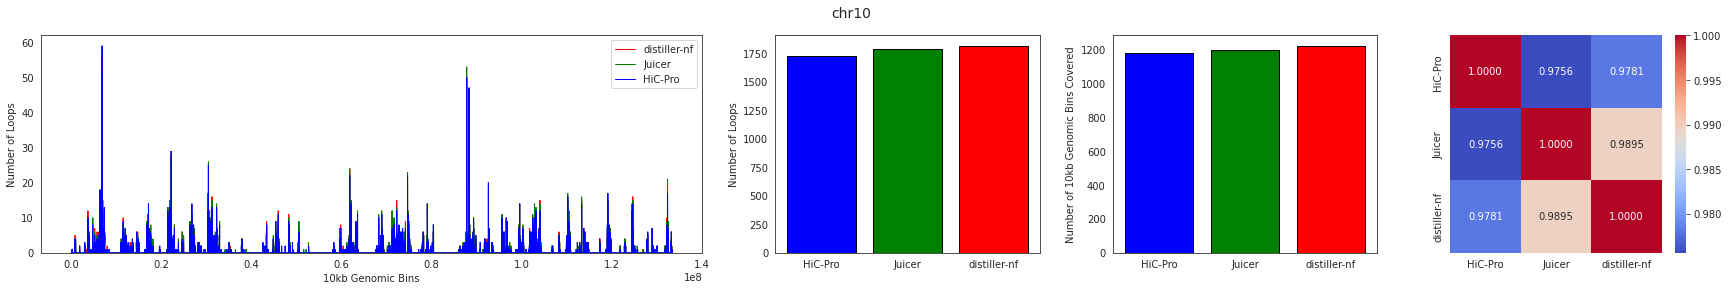

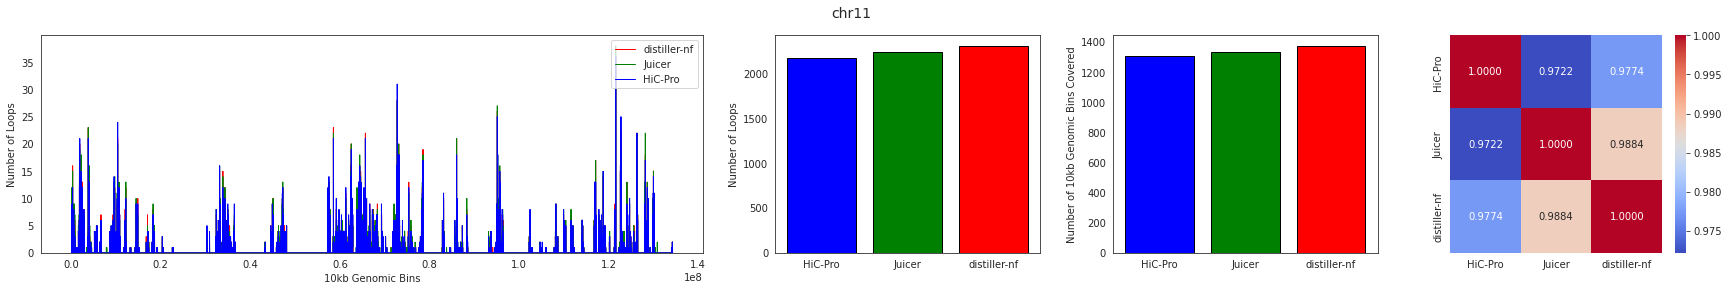

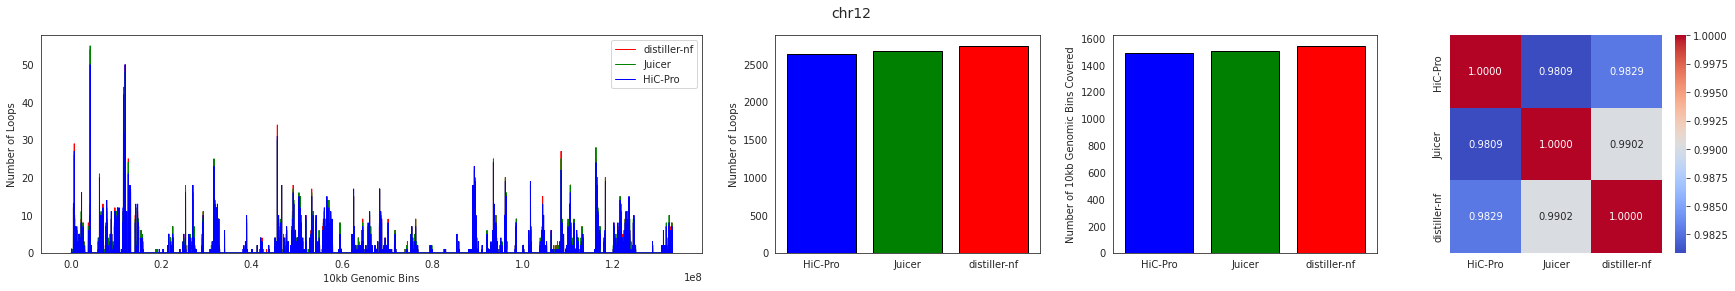

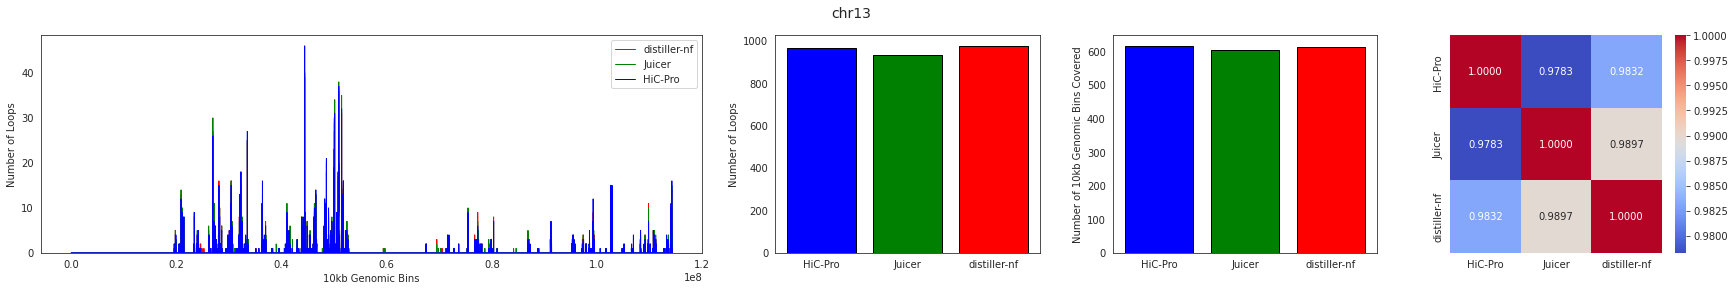

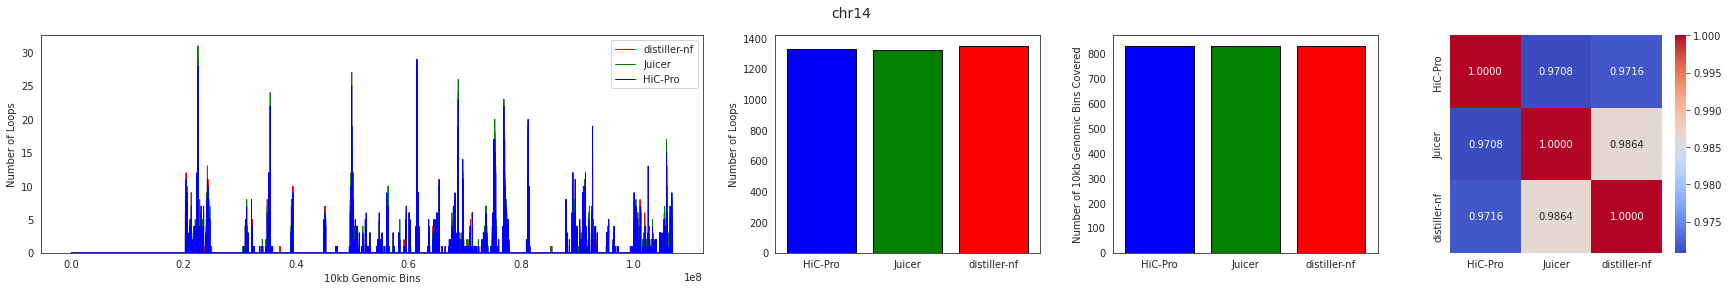

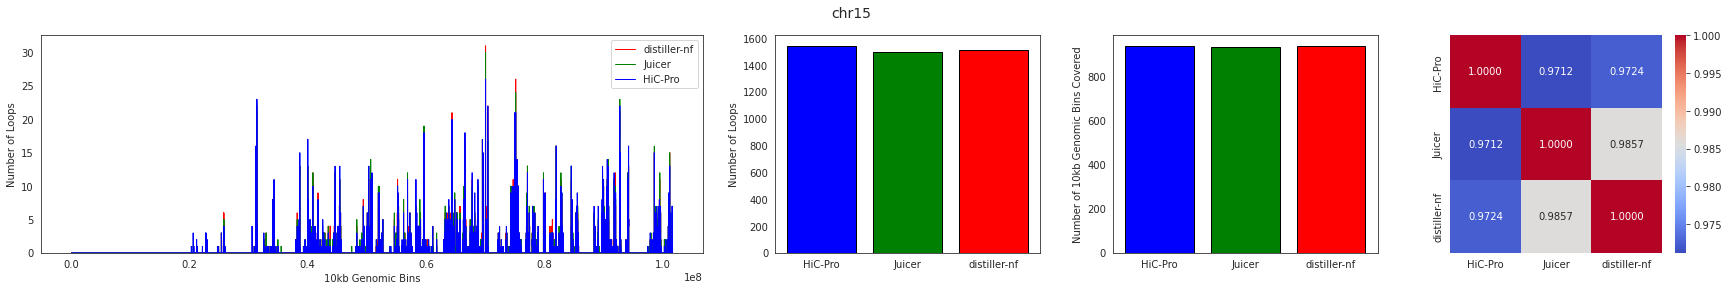

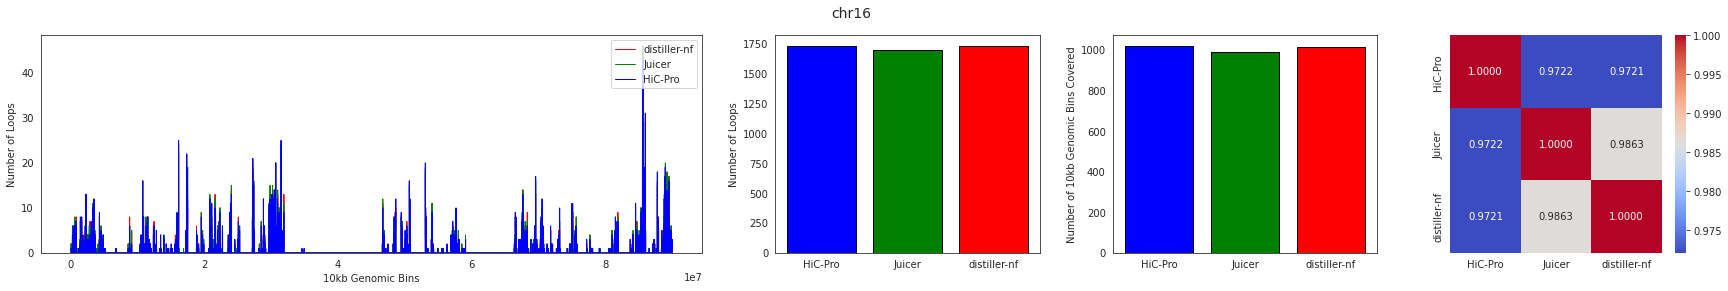

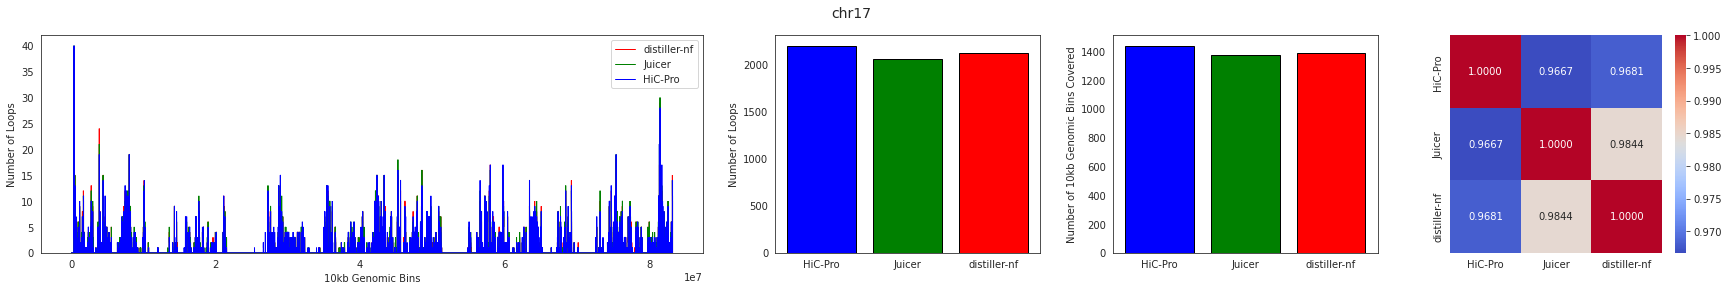

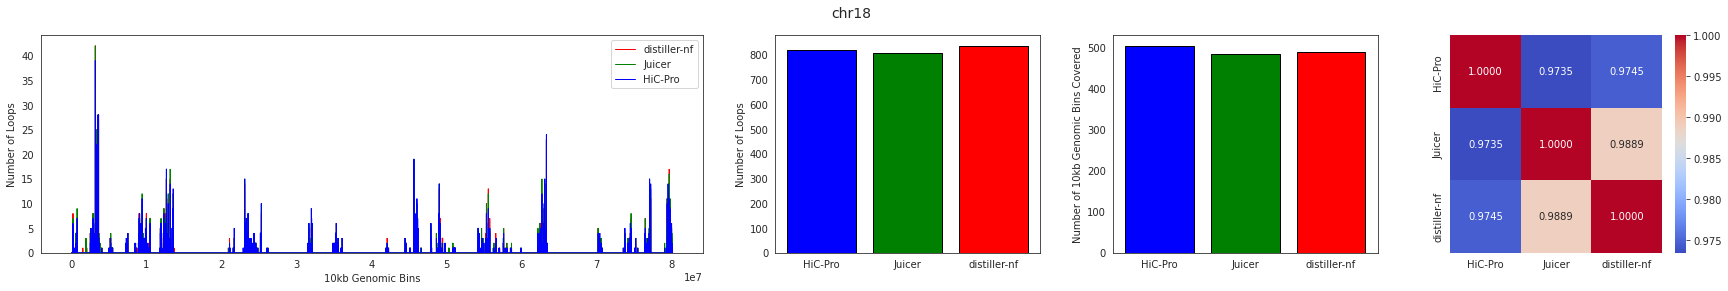

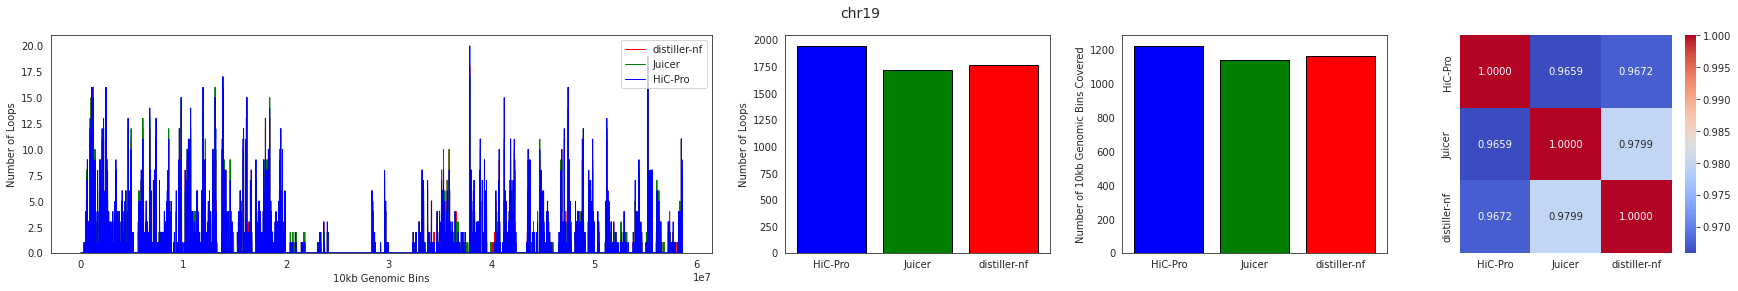

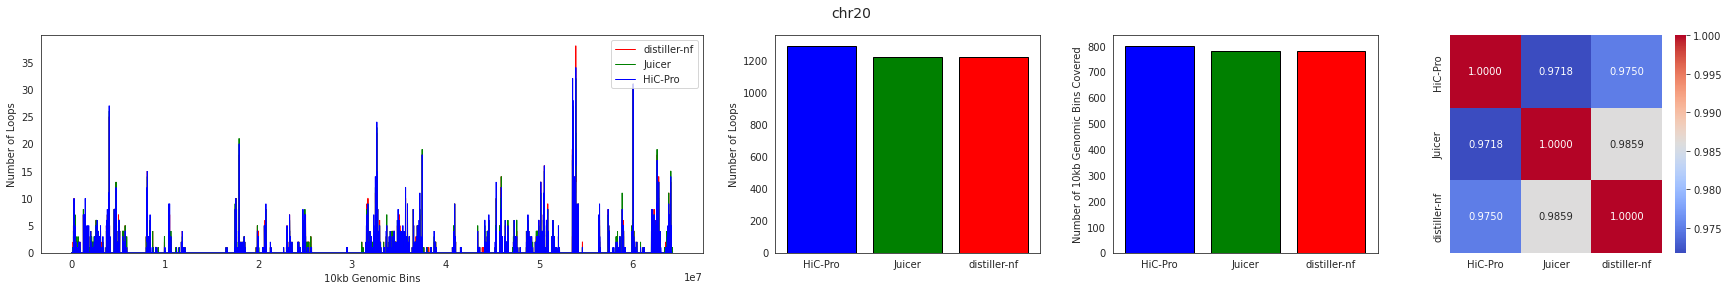

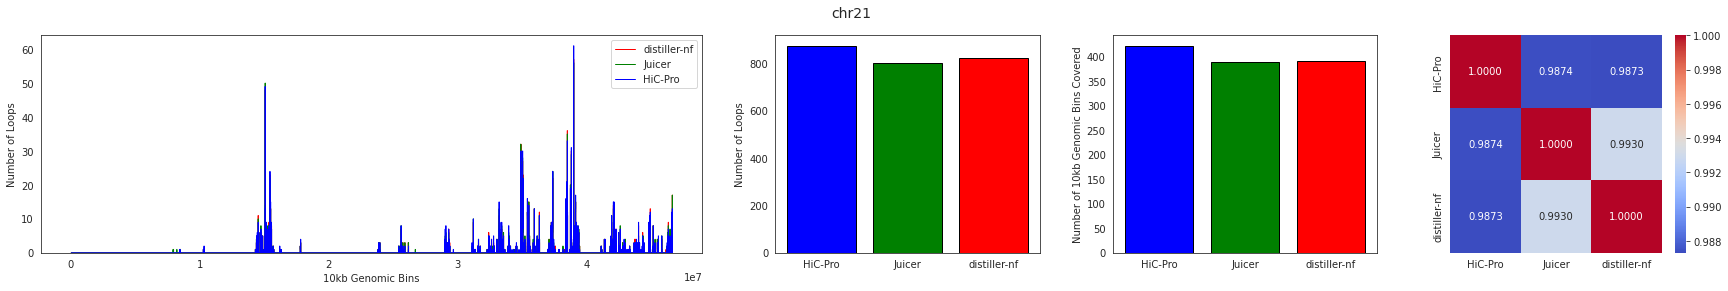

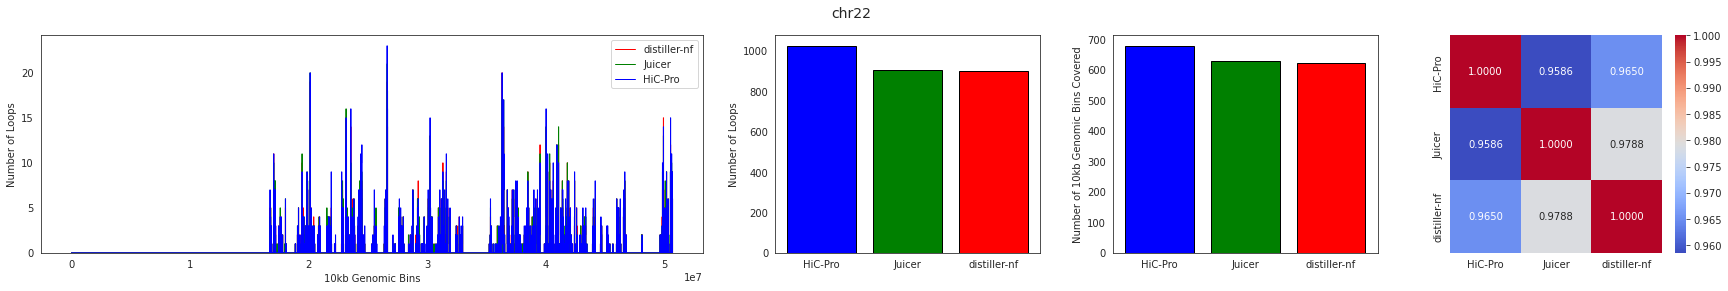

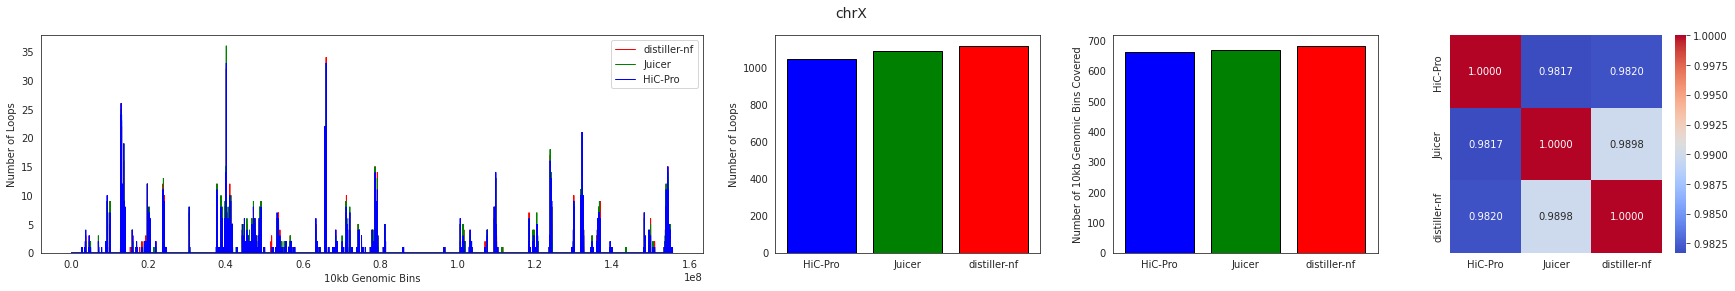

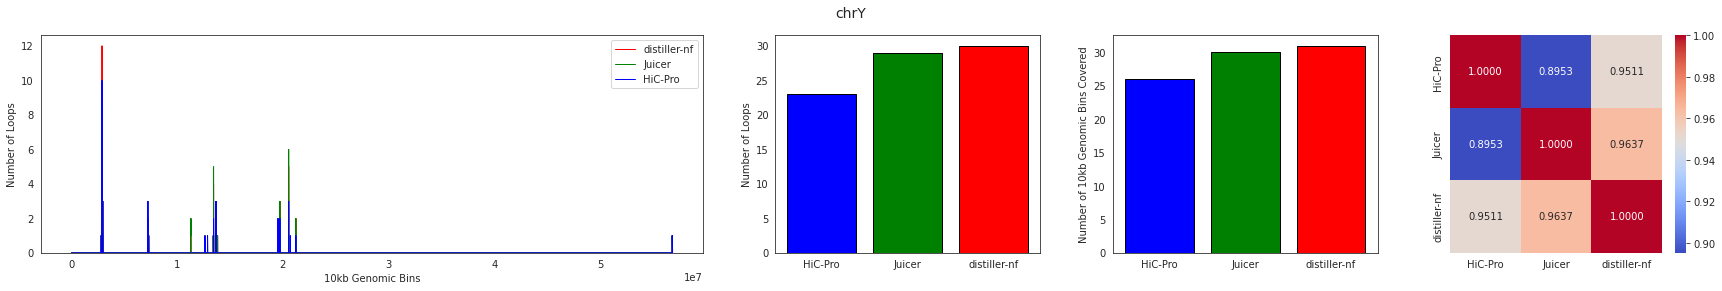

In [248]:
chroms = ["chr" + str(n) for n in range(1, 23)]
chroms.append("chrX")
chroms.append("chrY")
for chrom in chroms:
    get_coverage(chrom, "loops")